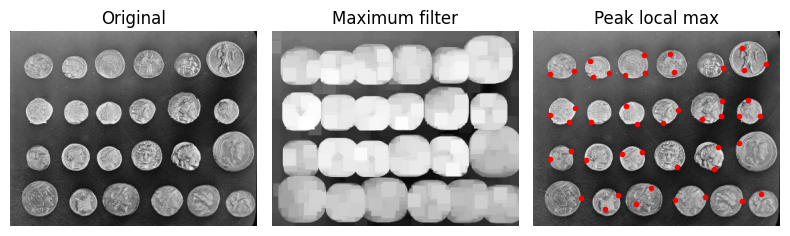

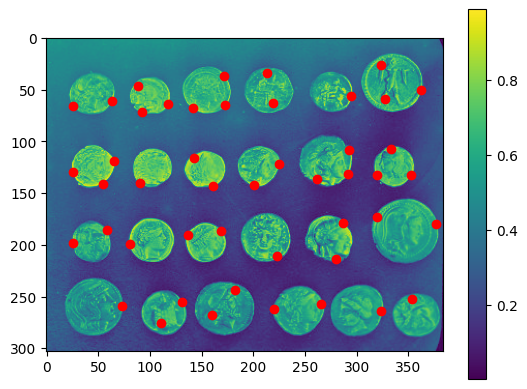

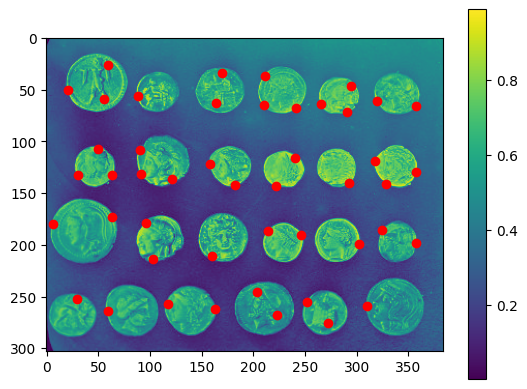

In [5]:
import torch.nn.functional as F

def find_all_local_maxima(image, neighborhood_size, minimum_value=0.5):
        """
        helper function for peak_local_max that finds all the local maxima
        within each neighbourhood. (may return multiple per neighbouhood).
        """
        # Perform max pooling with the specified neighborhood size
        kernel_size = 2*neighborhood_size + 1
        pooled = F.max_pool2d(image, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)

        # Create a mask for the local maxima
        mask = (pooled == image) * (image >= minimum_value)

        # Apply the mask to the original image to retain only the local maxima values
        local_maxima = image * mask

        return local_maxima
    
    
def torch_peak_local_max(image, neighbourhood_size, minimum_value):
    """
    computes peak local maxima function for an image (or batch of images), returning a maxima mask
    and the coordinates of the peak local max values.
    peak local maxima returns a image that is zero at all points other than local maxima.
    At the local maxima, the pixel retains its value in the original image.
    
    image: a torch tensor of shape [B,1,H,W] or [H,W], B is batch size. H,W are spatial dims.
    neighbourhood_size: int. Only one maxima will be selected within a square patch of width 
        equal to the neighbourhood size (specifically the largest maxima in that neighbourhood).
        Where there are multiple local maxima with the largest value within the neighbourhood,
        the maxima furthest away from the origin (furthest by euclidian distance from pixel (0,0))
        is retained (ensuring there is only one maxima per neighbourhood).
    minimum_value: float. Local maxima with pixel intensity below this value are ignored.
    
    returns: a torch tensor of shape equal to image, a list of length B containing (lx, ly) pairs
    where lx and ly are torch tensors containing the x and y coordinates of each local maxima for a given image.
    if image has shape [H,W], returns (lx, ly). 
    """
    
    assert len(image.shape) == 2 or len(image.shape) == 4
    single_image=False
    if len(image.shape) == 4:
        assert image.shape[1] == 1
    if len(image.shape) == 2:
        image = image.view(1, 1, *image.shape)
        single_image=True
        
    
    
    all_local_maxima = find_all_local_maxima(image, neighbourhood_size, minimum_value)
    
   # perform non-maximal coordinate supression to only get one maxima per neighbourhood.
    # specifically, where there are two maxima in a neighbourhood, I retain the maxima
    # which has the furthest euclidian distance away from the origin. This is just an
    # 'arbitrary' way for me to split the ties. 
    spatial_dims = [image.shape[-2], image.shape[-1]]
    grid = torch.stack(
                torch.meshgrid(
                    *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                    indexing='ij'
                )
            ).type(torch.float32).to(image.device)
    distance_to_origin = grid.unsqueeze(0).square().sum(dim=1).sqrt()
    distance_of_max_poses = all_local_maxima * distance_to_origin
    retained_maxima = find_all_local_maxima(distance_of_max_poses, neighbourhood_size, minimum_value=0)
    peak_local_max = all_local_maxima * (retained_maxima > 0)
    
    
    locs = [torch.where(lm.squeeze()) for lm in peak_local_max] # one list per image in the batch
    if single_image:
        peak_local_max = peak_loca_max.squeeze()
        locs = locs[0]
        

    return peak_local_max, locs
    
    
##### SIMPLE WORKING EXAMPLE
##### THE SCIPY METHOD FIRST FOR COMPARISON
import numpy as np
import torch
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

im = img_as_float(data.coins())

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(im, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=20)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

#### THE TORCH IMPLEMENTATION
#### HERE I SHOW HOW IT CAN BE APPLIED TO A BATCH OF IMAGES
im_tensor = torch.stack([torch.Tensor(im), torch.Tensor(im).flip(-1), ]).unsqueeze(1)
maxima, locs = torch_peak_local_max(im_tensor, neighbourhood_size=20, minimum_value=0.6)


plt.imshow(im_tensor[0][0]); plt.colorbar()
plt.scatter(locs[0][1], locs[0][0], c='r')
plt.show()

plt.imshow(im_tensor[1][0]); plt.colorbar()
plt.scatter(locs[1][1], locs[1][0], c='r')
plt.show()